## Imports

In [108]:
import wfdb
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
from tqdm import tqdm
import math
from wfdb import processing
from numpy.linalg import norm
import cv2
from sklearn.cluster import KMeans,MeanShift
from sklearn.cluster import DBSCAN
from skimage.segmentation import quickshift,felzenszwalb

## Data

In [85]:
## Getting path image
path_img = 'Base\\Myocardial infarction\\patient003_s0017lre_12d_Myocardialinfarction_anterior_886-5886.png'

In [5]:
## Extracting infos from path
infos_path = path_img.split('\\')[2].split('_')
patient, record, start, end = infos_path[0], infos_path[1], int(infos_path[-1].replace(".png", "").split('-')[0]), int(infos_path[-1].replace(".png", "").split('-')[1])

In [7]:
## Read the signal
sign, fields = wfdb.rdsamp(f'ptb-diagnostic-ecg-database-1.0.0/{patient}/{record}', channels=[*range(15)])

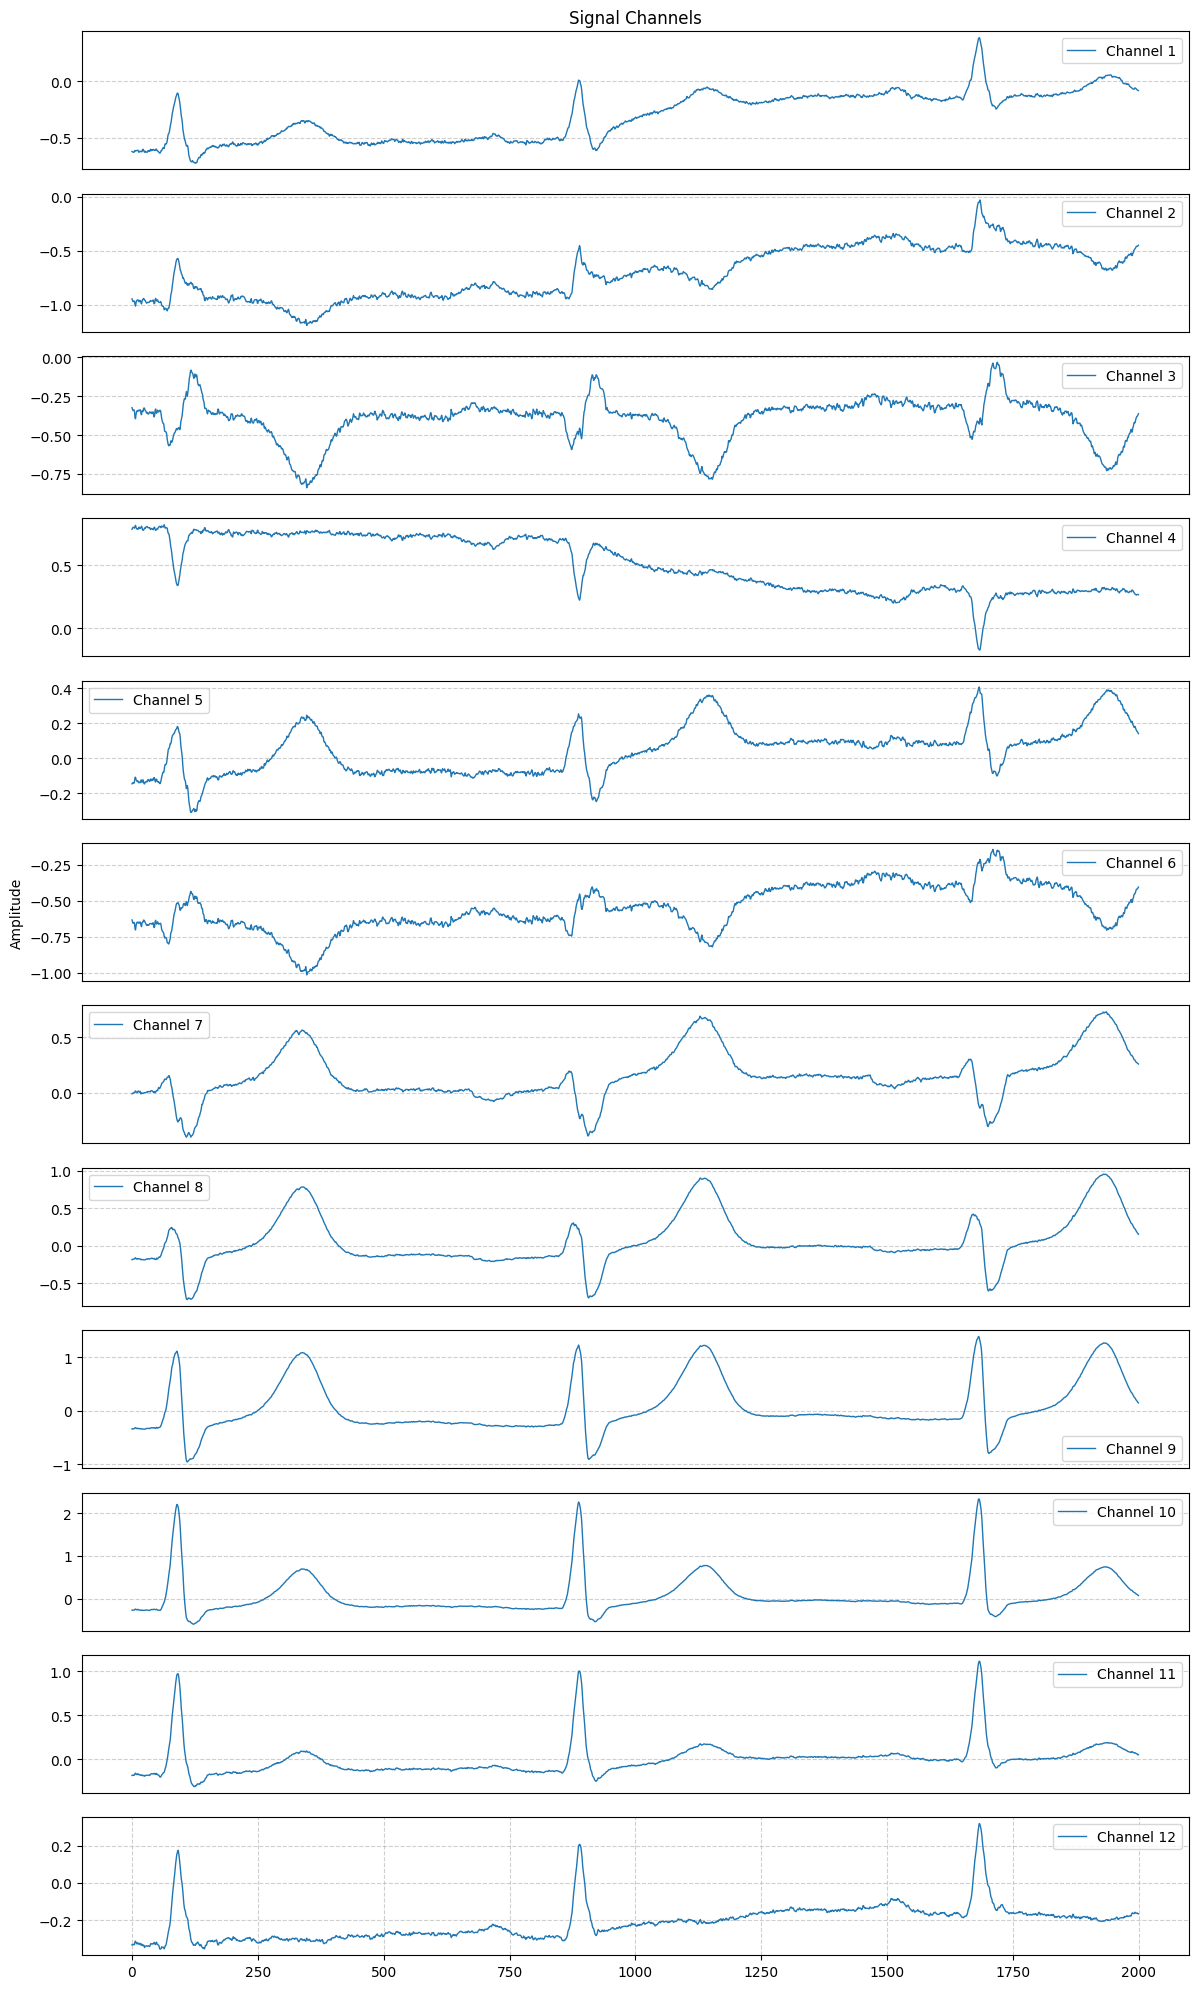

In [8]:
# Extract the first 1500 samples from the first 12 channels
sig = sign[:, :12][0:2000]

# Create a new figure with a larger size
plt.figure(figsize=(12, 20))

# Plot each signal channel in a different subplot with some style
for i in range(12):
    ax = plt.subplot(12, 1, i + 1)
    
    # Plot the signal
    plt.plot(sig[:, i], label=f'Channel {i+1}', linewidth=1)
    
    # Add some style
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    
    # Remove x-axis ticks for all but the last subplot
    if i < 11:
        plt.xticks([])
    
    # Add y-axis label for the middle subplot
    if i == 5:
        plt.ylabel('Amplitude')
    
    # Add a title for the entire plot
    if i == 0:
        plt.title('Signal Channels')
    
# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()


## Linha de Base

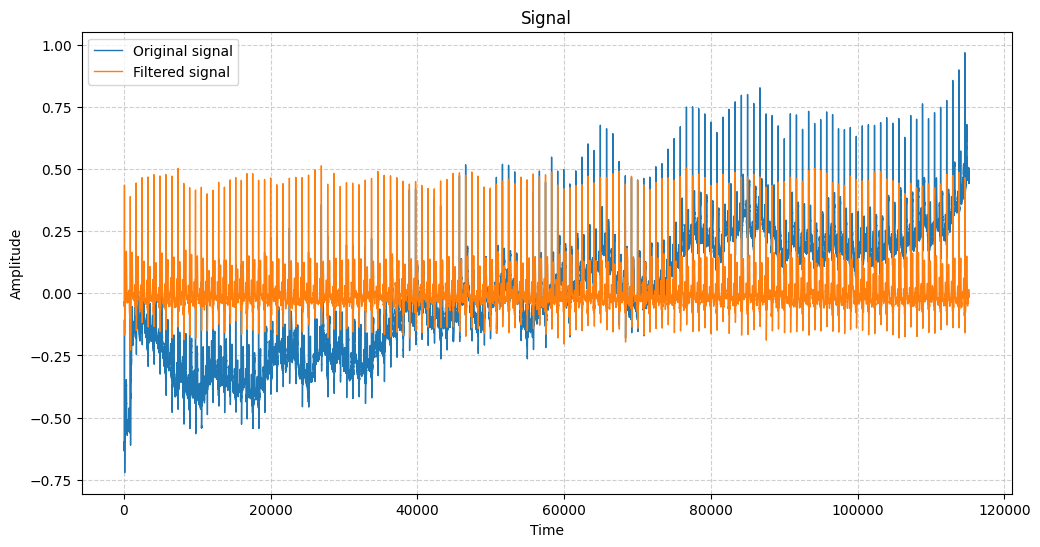

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

sign = sign[:, :12]

def filt_bandpass(sig,fs):
    '''
    Filtro Butterworth passa banda, ordem 3. Frequência de corte 1hz e 50hz.
    :param sig: sinal a ser filtrado
    :param fs: frequência de amostragem do sinal.
    :return sig_filt: sinal filtrado.
    '''
    
    nyq = 0.5*fs # frequência de Nyquist
    ordem = 3 # ordem do filtro
    fh = 50
    fl = 1
    high = fh/nyq
    low = fl/nyq
    b, a = signal.butter(ordem, [low, high], btype='band')
    sig_filt = signal.filtfilt(b, a, sig, axis = 0)
        
    return sig_filt

filt_sign = filt_bandpass(sign,1000)

# Plot signal before and after filtering
plt.figure(figsize=(12, 6))
plt.plot(sign[:, 0], label='Original signal', linewidth=1)
plt.plot(filt_sign[:, 0], label='Filtered signal', linewidth=1)
plt.legend()
plt.title('Signal')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


## Distance Matrix

In [87]:
def show_matrix(matrix,map='jet',show=True,return_img=False):
    '''
    Função para plotar uma matriz de valores.
    :param matrix: matriz de valores.
    :param map: cmap do matplotlib.
    :param show: se True, plota a imagem.
    :param return_img: se True, retorna a imagem.
    '''
    # Obtain the colormap
    colormap = plt.cm.get_cmap(map)
    # Normalize the intensity values
    norm = plt.Normalize(vmin=np.min(matrix), vmax=np.max(matrix))
    # Map intensity values to RGBA using the colormap
    rgb_image = colormap(norm(np.abs(matrix)))[:, :, :3]  # Discard the alpha channel
    if show:
        fig, ax = plt.subplots()
        ax.imshow(np.abs(matrix), cmap=map)
        plt.show()
    if return_img:
        return rgb_image

In [90]:
def generate_image(signal):
  '''
  Função para gerar a matriz de distância a partir de um sinal utilizando a distância euclidiana.
  :param signal: sinal a ser utilizado.
  '''
  diffs = signal[:, np.newaxis, :] - signal[np.newaxis, :, :]
  dists = norm(diffs, axis=2)
  l = np.concatenate((l, dists), axis=0) if 'l' in locals() else dists
  return l

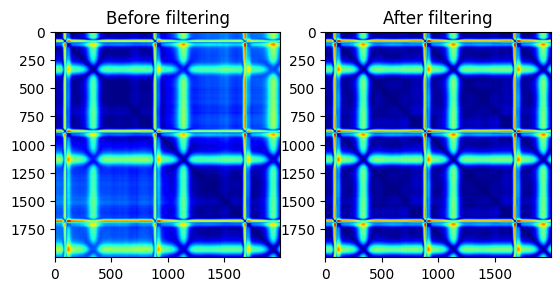

In [95]:
## Plotting a sample from the signal before and after the transformation
sig = filt_sign[0:2000]
matrix_dist = generate_image(sig)
matrix_img = show_matrix(matrix_dist,return_img=True,show=False)
matrix_img_bef = show_matrix(generate_image(sign[0:2000]),return_img=True,show=False)
## Show matrix_img and matrix_img_bef in subplots
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(matrix_img_bef)
ax2.imshow(matrix_img)
ax1.title.set_text('Before filtering')
ax2.title.set_text('After filtering')
plt.show()

### Distância R-R

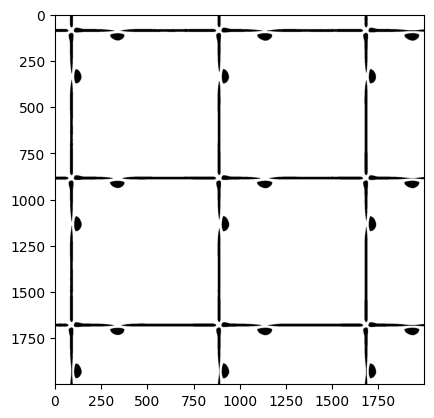

In [96]:
## Get quantiles from matrix
quantiles = np.quantile(matrix_dist, [0.25, 0.5, 0.95])
## Applying a threshold to the matrix on 0.95 quantile
matrix_dist_t = (matrix_dist < quantiles[2])*255
show_matrix(matrix_dist_t,map="gray")

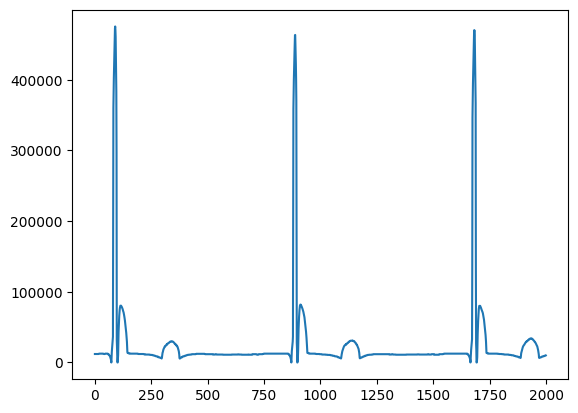

In [97]:
## Plotting the sum of the matrix columns
matrix_dist_bin = 255 - matrix_dist_t
sums = []
for i in range(matrix_dist_bin.shape[0]):
    sums.append(sum(matrix_dist_bin[:, i]))
plt.plot(sums)
plt.show()

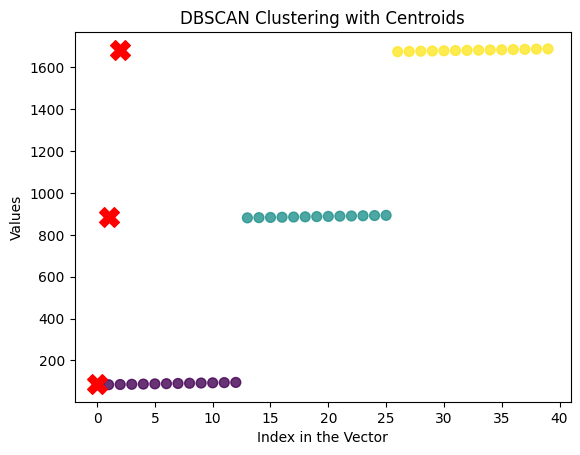

In [99]:
## Identifying peaks from the sum of the matrix columns
peaks = []
first_last = {}
for i in range(matrix_dist_bin.shape[0]):
    if sum(matrix_dist_bin[:, i]) > np.percentile(sums, 98):
        peaks.append(i)
        
# Data vector
data = np.array(peaks)

# Reshape the vector to be a two-dimensional matrix
data_reshaped = data.reshape(-1, 1)

# Apply DBSCAN
dbscan = DBSCAN(eps=100, min_samples=2)
labels = dbscan.fit_predict(data_reshaped)

# Find the mean for each cluster
unique_labels = np.unique(labels)
centroids = []

for label in unique_labels:
    if label == -1:  # Skip noise points
        continue
    cluster_points = data[labels == label]
    cluster_mean = np.mean(cluster_points)
    centroids.append(cluster_mean)
    first_last[label] = [min(cluster_points), max(cluster_points)]

# Plot the results with centroids
plt.scatter(range(len(data)), data, c=labels, cmap='viridis', s=50, alpha=0.8)
plt.scatter(range(len(centroids)), centroids, c='red', marker='X', s=200)
plt.title('DBSCAN Clustering with Centroids')
plt.xlabel('Index in the Vector')
plt.ylabel('Values')
plt.show()

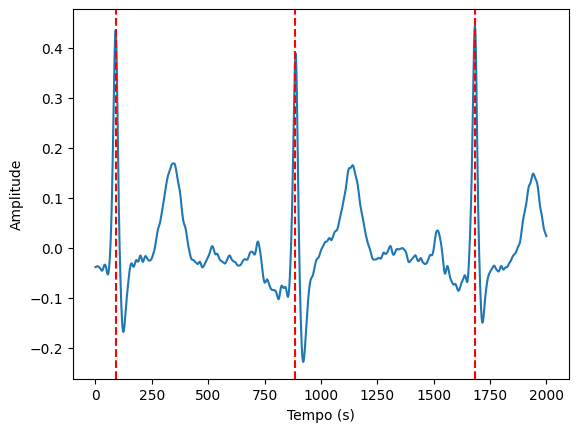

In [101]:
## Plot centroids with a line on signal
t = np.linspace(0, len(sig), len(sig))
plt.plot(t, sig[:,0], label='Sinal original')
for i in centroids:
    plt.axvline(x=i, color='r', linestyle='--')
plt.xlabel('Tempo (s)')
plt.ylabel('Amplitude')
plt.show()

In [102]:
## Calculating R-R interval and heart rate
rr = []
hr = []
fs = 1000
for i in range(len(centroids)-1):
    diff = (centroids[i+1] - centroids[i])/fs
    rr.append(diff)
    hr.append(60/diff)
print(rr)
print(hr)

[0.798, 0.7945]
[75.18796992481202, 75.51919446192574]


### T Wave

#### Thesholding

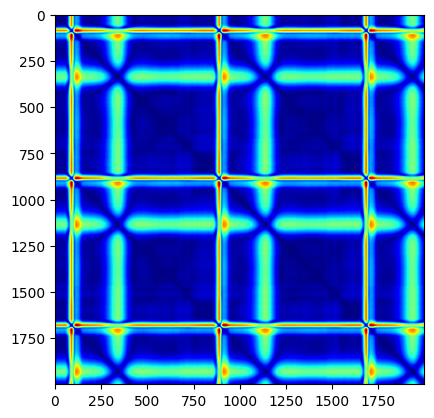

In [103]:
show_matrix(matrix_dist)

(786, 786)


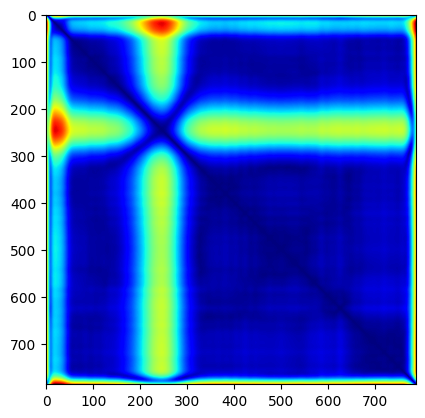

In [105]:
## crop matrix_dist on first_last from two first clusters
matrix_dist_crop = matrix_dist[first_last[0][1]:first_last[1][0],first_last[0][1]:first_last[1][0]]

print(matrix_dist_crop.shape)
show_matrix(matrix_dist_crop)

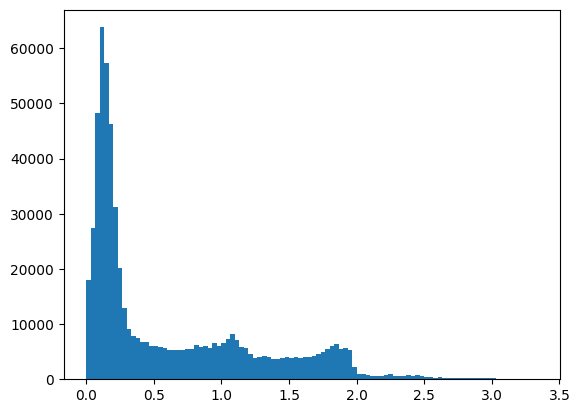

In [106]:
## Plotting histogram from matrix_dist_crop
plt.hist(matrix_dist_crop.flatten(), bins=100)
plt.show()

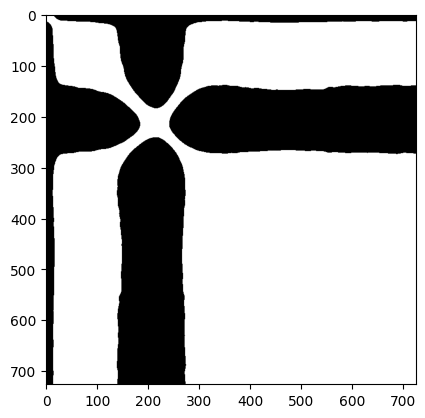

In [25]:
## Applying threshold
matrix_dist_crop_blur_t = (matrix_dist_crop < 0.5)*255
show_matrix(matrix_dist_crop_blur_t,map = 'gray')
## This is ok, but not too good, let's try another approach

#### Clusterization

In [117]:
def float_to_unint(flot_img):
    '''
    Função para converter uma imagem de float para uint8.
    :param flot_img: imagem em float.
    :return uint8_image: imagem em uint8.
    '''
    # Clip values to the range [0, 1]
    clipped_image = np.clip(flot_img, 0, 1)

    # Scale to the range [0, 255] and convert to uint8
    uint8_image = (clipped_image * 255).astype(np.uint8)
    return uint8_image

In [118]:
matrix_crop_img = show_matrix(matrix_dist_crop,show=False,return_img=True)
matrix_unint = float_to_unint(matrix_crop_img)

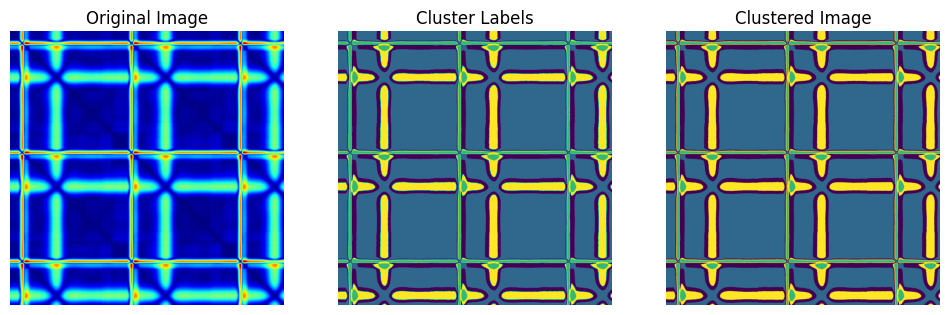

In [119]:
# Reshape the image to a 2D array of pixels (rows, columns, channels)
image = float_to_unint(show_matrix(matrix_dist,return_img=True,show=False))
pixels = image.reshape((-1, 3))  # Assuming it's a 3-channel (RGB) image

# Choose the number of clusters (k)
k = 4

# Apply KMeans clustering
kmeans = KMeans(n_clusters=k, random_state=0)
labels = kmeans.fit_predict(pixels)

# Reshape the labels to the original image shape
labels_reshaped = labels.reshape(image.shape[:2])

# Assign unique colors to each cluster label
unique_labels = np.unique(labels_reshaped)
num_clusters = len(unique_labels)
colors = plt.cm.viridis(np.linspace(0, 1, num_clusters))[:, :3]  # Use viridis colormap

# Create a colored image based on cluster labels
colored_image = colors[labels_reshaped]

# Display the original and clustered images
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.imshow(image,cmap='jet')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(labels_reshaped, cmap='viridis')
plt.title('Cluster Labels')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(colored_image)
plt.title('Clustered Image')
plt.axis('off')

plt.show()

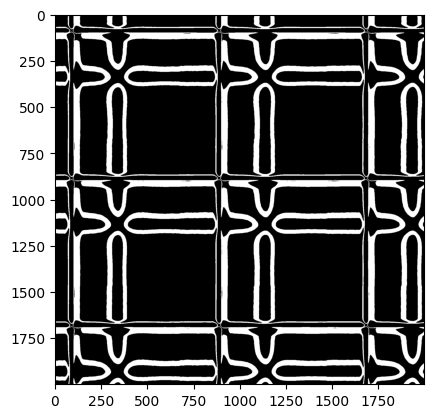

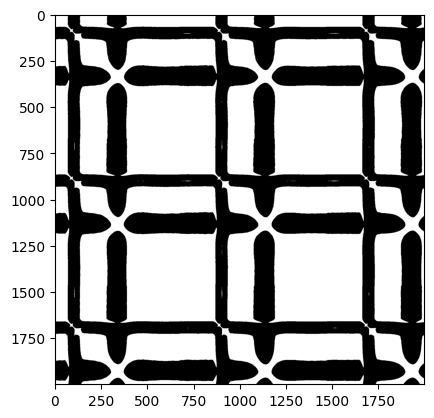

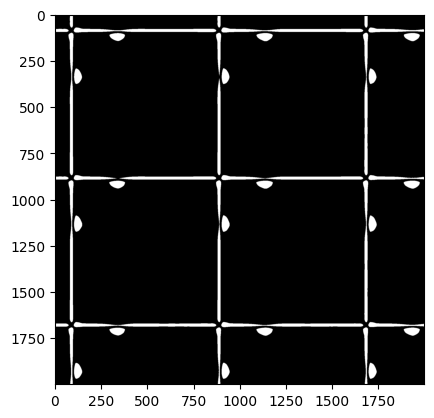

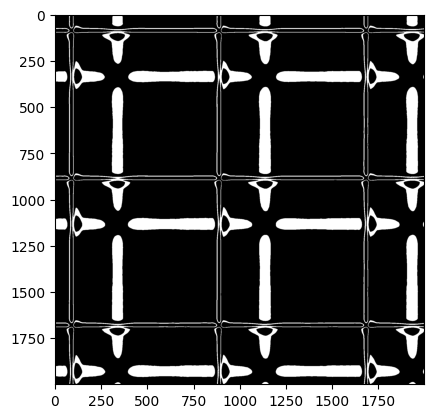

In [120]:
## Show each cluster separately
for i in range(k):
    label_choose = i
    matrix_dist_crop_blur_t = (labels_reshaped == label_choose)*255
    show_matrix(matrix_dist_crop_blur_t,map = 'gray')

### P Wave

## Others tools

### Anisotropic Diffusion

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from medpy.filter.smoothing import anisotropic_diffusion

# Apply anisotropic diffusion smoothing
smoothed_image = anisotropic_diffusion(uint8_image, niter=10, kappa=50)

# Display the original and smoothed images
plt.subplot(1, 2, 1), plt.imshow(uint8_image, cmap='jet')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])

plt.subplot(1, 2, 2), plt.imshow(smoothed_image, cmap='jet')
plt.title('Smoothed Image'), plt.xticks([]), plt.yticks([])

plt.show()